<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [VAE1] - First VAE, with a small dataset (MNIST)
<!-- DESC --> Construction and training of a VAE with a latent space of small dimension.

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a **variational autoencoder** neurals network (VAE)
 - Understanding a more **advanced programming model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST to start with.

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Follow the learning process with Tensorboard

## Acknowledgements :
Thanks to **François Chollet** who is at the base of this example.  
François Chollet is not only the author of Keras and a great guru, he is also a sorcerer ;-)  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np
from skimage import io

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import os,sys,json,time,datetime
from IPython.display import display,Image,Markdown,HTML

from modules.VAE          import VAE, Sampling
from modules.loader_MNIST import Loader_MNIST
from modules.callbacks    import ImagesCallback, BestModelCallback

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/MNIST.001'                     # Output directory
datasets_dir = pwk.init('VAE1', run_dir)

VAE.about()

**\*\* Overrided parameters : \*\***

run_dir              : ./run/VAE1_done


<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.12
Notebook id          : VAE1
Run time             : Tuesday 09 February 2021, 19:58:35
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/VAE1_done
Update keras cache   : False
Save figs            : True
Path figs            : ./run/VAE1_done/figs


<br>**FIDLE 2021 - VAE**

Version              : 1.2
TensorFlow version   : 2.4.0
Keras version        : 2.4.0


## Step 2 - Parameters
Uncomment the right lines according to what you want.

In [2]:
# ---- Smart tests
#
latent_dim    = 2
r_loss_factor = 0.994
scale         = 0.1
batch_size    = 64
epochs        = 10

# ---- Full run (1'30 on a V100)
#
# latent_dim    = 2
# r_loss_factor = 0.994
# scale         = 1.
# batch_size    = 64
# epochs        = 10

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('scale', 'latent_dim', 'r_loss_factor', 'batch_size', 'epochs')

**\*\* Overrided parameters : \*\***

scale                : 1
latent_dim           : 2
r_loss_factor        : 0.994
batch_size           : 64
epochs               : 10


## Step 3 - Prepare data
### 3.1 - Get it

In [4]:
x_train, _ = Loader_MNIST.get()
np.random.shuffle(x_train)
nb_images = int(len(x_train)*scale)
x_train   = x_train[:nb_images]
print('\nTrain shape after rescale : ',x_train.shape)

Dataset loaded.
Normalized.
Expanded.
Concatenate.
x shape : (70000, 28, 28, 1)
y shape : (70000,)



Train shape after rescale :  (70000, 28, 28, 1)


### 3.2 - Have a look

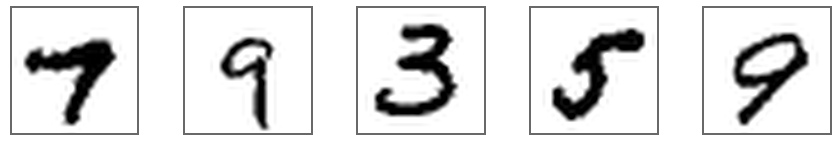

In [5]:
pwk.plot_images(x_train[:5], None, indices='all', columns=5, x_size=3,y_size=2, save_as='01-original')

## Step 4 - Build model

#### Encoder

In [6]:
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, strides=1, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = Sampling()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.compile()
# encoder.summary()

#### Decoder

In [7]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.compile()
# decoder.summary()

#### VAE
Our loss function is the weighted sum of two values.  
`reconstruction_loss` which measures the loss during reconstruction.  
`kl_loss` which measures the dispersion.  

The weights are defined by: `r_loss_factor` :  
`total_loss = r_loss_factor*reconstruction_loss + (1-r_loss_factor)*kl_loss`

if `r_loss_factor = 1`, the loss function includes only `reconstruction_loss`  
if `r_loss_factor = 0`, the loss function includes only `kl_loss`  
In practice, a value of 0.3 gives good results here.


In [8]:
vae = VAE(encoder, decoder, r_loss_factor)

vae.compile(optimizer=keras.optimizers.Adam())

Init VAE, with r_loss_factor=0.994


## Step 5 - Train
With `scale=1`, need 1'15 on a GPU (V100 at IDRIS) ...or 20' on a CPU  

In [9]:
# ---- Callback : Images encoded
pwk.mkdir(run_dir + '/images-encoded')
filename = run_dir + '/images-encoded/image-{epoch:03d}-{i:02d}.jpg'
callback_images1 = ImagesCallback(filename, x=x_train[:5], encoder=encoder,decoder=decoder)

# ---- Callback : Images generated
pwk.mkdir(run_dir + '/images-generated')
filename = run_dir + '/images-generated/image-{epoch:03d}-{i:02d}.jpg'
callback_images2 = ImagesCallback(filename, x=None, nb_images=5, z_dim=2, encoder=encoder,decoder=decoder)          

# ---- Callback : Best model
pwk.mkdir(run_dir + '/models')
filename = run_dir + '/models/best_model'
callback_bestmodel = BestModelCallback(filename)

# ---- Callback tensorboard
dirname = run_dir + '/logs'
callback_tensorboard = TensorBoard(log_dir=dirname, histogram_freq=1)

# callbacks_list = [callback_images1, callback_images2, callback_bestmodel, callback_tensorboard]
callbacks_list = [callback_images1, callback_images2, callback_bestmodel]

In [10]:
pwk.chrono_start()

history = vae.fit(x_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list,)

pwk.chrono_show()

Epoch 1/10


   1/1094 [..............................] - ETA: 1:07:01 - loss: 0.6896 - r_loss: 0.6937 - kl_loss: 1.4846e-04

  12/1094 [..............................] - ETA: 4s - loss: 0.6736 - r_loss: 0.6777 - kl_loss: 0.0021         

  24/1094 [..............................] - ETA: 4s - loss: 0.5917 - r_loss: 0.5936 - kl_loss: 0.2725

  36/1094 [..............................] - ETA: 4s - loss: 0.5246 - r_loss: 0.5266 - kl_loss: 0.1827

  48/1094 [>.............................] - ETA: 4s - loss: 0.4714 - r_loss: 0.4734 - kl_loss: 0.1378

  60/1094 [>.............................] - ETA: 4s - loss: 0.4320 - r_loss: 0.4339 - kl_loss: 0.1114

  72/1094 [>.............................] - ETA: 4s - loss: 0.4046 - r_loss: 0.4065 - kl_loss: 0.0937

  84/1094 [=>............................] - ETA: 4s - loss: 0.3852 - r_loss: 0.3870 - kl_loss: 0.0810

  96/1094 [=>............................] - ETA: 4s - loss: 0.3705 - r_loss: 0.3724 - kl_loss: 0.0717

 108/1094 [=>............................] - ETA: 4s - loss: 0.3590 - r_loss: 0.3608 - kl_loss: 0.0656

 120/1094 [==>...........................] - ETA: 4s - loss: 0.3492 - r_loss: 0.3509 - kl_loss: 0.0733

 132/1094 [==>...........................] - ETA: 4s - loss: 0.3414 - r_loss: 0.3428 - kl_loss: 0.1128

 144/1094 [==>...........................] - ETA: 4s - loss: 0.3349 - r_loss: 0.3360 - kl_loss: 0.1534

 156/1094 [===>..........................] - ETA: 4s - loss: 0.3291 - r_loss: 0.3299 - kl_loss: 0.1958

 168/1094 [===>..........................] - ETA: 4s - loss: 0.3238 - r_loss: 0.3243 - kl_loss: 0.2354

 180/1094 [===>..........................] - ETA: 3s - loss: 0.3194 - r_loss: 0.3197 - kl_loss: 0.2734

 192/1094 [====>.........................] - ETA: 3s - loss: 0.3156 - r_loss: 0.3157 - kl_loss: 0.2989

 204/1094 [====>.........................] - ETA: 3s - loss: 0.3123 - r_loss: 0.3122 - kl_loss: 0.3280

 215/1094 [====>.........................] - ETA: 3s - loss: 0.3091 - r_loss: 0.3089 - kl_loss: 0.3538

 225/1094 [=====>........................] - ETA: 3s - loss: 0.3069 - r_loss: 0.3065 - kl_loss: 0.3758

 235/1094 [=====>........................] - ETA: 3s - loss: 0.3046 - r_loss: 0.3040 - kl_loss: 0.4018

 245/1094 [=====>........................] - ETA: 3s - loss: 0.3024 - r_loss: 0.3017 - kl_loss: 0.4175

 255/1094 [=====>........................] - ETA: 3s - loss: 0.3004 - r_loss: 0.2996 - kl_loss: 0.4348

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2986 - r_loss: 0.2976 - kl_loss: 0.4553

 276/1094 [======>.......................] - ETA: 3s - loss: 0.2969 - r_loss: 0.2958 - kl_loss: 0.4701

 287/1094 [======>.......................] - ETA: 3s - loss: 0.2952 - r_loss: 0.2941 - kl_loss: 0.4863

 297/1094 [=======>......................] - ETA: 3s - loss: 0.2938 - r_loss: 0.2926 - kl_loss: 0.4973

 307/1094 [=======>......................] - ETA: 3s - loss: 0.2923 - r_loss: 0.2910 - kl_loss: 0.5162

 317/1094 [=======>......................] - ETA: 3s - loss: 0.2910 - r_loss: 0.2896 - kl_loss: 0.5306

 327/1094 [=======>......................] - ETA: 3s - loss: 0.2898 - r_loss: 0.2883 - kl_loss: 0.5396

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2888 - r_loss: 0.2872 - kl_loss: 0.5522

 347/1094 [========>.....................] - ETA: 3s - loss: 0.2876 - r_loss: 0.2859 - kl_loss: 0.5668

 357/1094 [========>.....................] - ETA: 3s - loss: 0.2866 - r_loss: 0.2848 - kl_loss: 0.5784

 367/1094 [=========>....................] - ETA: 3s - loss: 0.2855 - r_loss: 0.2836 - kl_loss: 0.5907

 377/1094 [=========>....................] - ETA: 3s - loss: 0.2845 - r_loss: 0.2826 - kl_loss: 0.6030

 387/1094 [=========>....................] - ETA: 3s - loss: 0.2836 - r_loss: 0.2817 - kl_loss: 0.6119

 397/1094 [=========>....................] - ETA: 3s - loss: 0.2827 - r_loss: 0.2807 - kl_loss: 0.6215

 407/1094 [==========>...................] - ETA: 3s - loss: 0.2818 - r_loss: 0.2796 - kl_loss: 0.6322

 417/1094 [==========>...................] - ETA: 3s - loss: 0.2809 - r_loss: 0.2787 - kl_loss: 0.6424

 427/1094 [==========>...................] - ETA: 3s - loss: 0.2801 - r_loss: 0.2778 - kl_loss: 0.6520

 437/1094 [==========>...................] - ETA: 3s - loss: 0.2794 - r_loss: 0.2771 - kl_loss: 0.6612

 447/1094 [===========>..................] - ETA: 3s - loss: 0.2786 - r_loss: 0.2762 - kl_loss: 0.6690

 457/1094 [===========>..................] - ETA: 3s - loss: 0.2779 - r_loss: 0.2755 - kl_loss: 0.6773

 467/1094 [===========>..................] - ETA: 2s - loss: 0.2773 - r_loss: 0.2748 - kl_loss: 0.6870

 477/1094 [============>.................] - ETA: 2s - loss: 0.2766 - r_loss: 0.2740 - kl_loss: 0.6950

 487/1094 [============>.................] - ETA: 2s - loss: 0.2759 - r_loss: 0.2733 - kl_loss: 0.7022

 497/1094 [============>.................] - ETA: 2s - loss: 0.2753 - r_loss: 0.2727 - kl_loss: 0.7101

 507/1094 [============>.................] - ETA: 2s - loss: 0.2747 - r_loss: 0.2721 - kl_loss: 0.7168

 517/1094 [=============>................] - ETA: 2s - loss: 0.2742 - r_loss: 0.2714 - kl_loss: 0.7238

 527/1094 [=============>................] - ETA: 2s - loss: 0.2735 - r_loss: 0.2708 - kl_loss: 0.7301

 537/1094 [=============>................] - ETA: 2s - loss: 0.2730 - r_loss: 0.2703 - kl_loss: 0.7351

 547/1094 [==============>...............] - ETA: 2s - loss: 0.2726 - r_loss: 0.2697 - kl_loss: 0.7414

 557/1094 [==============>...............] - ETA: 2s - loss: 0.2720 - r_loss: 0.2692 - kl_loss: 0.7490

 568/1094 [==============>...............] - ETA: 2s - loss: 0.2715 - r_loss: 0.2686 - kl_loss: 0.7556

 578/1094 [==============>...............] - ETA: 2s - loss: 0.2711 - r_loss: 0.2681 - kl_loss: 0.7607

 588/1094 [===============>..............] - ETA: 2s - loss: 0.2707 - r_loss: 0.2677 - kl_loss: 0.7660

 598/1094 [===============>..............] - ETA: 2s - loss: 0.2702 - r_loss: 0.2671 - kl_loss: 0.7740

 608/1094 [===============>..............] - ETA: 2s - loss: 0.2697 - r_loss: 0.2666 - kl_loss: 0.7796

 618/1094 [===============>..............] - ETA: 2s - loss: 0.2693 - r_loss: 0.2662 - kl_loss: 0.7859

 628/1094 [================>.............] - ETA: 2s - loss: 0.2689 - r_loss: 0.2657 - kl_loss: 0.7920

 638/1094 [================>.............] - ETA: 2s - loss: 0.2685 - r_loss: 0.2653 - kl_loss: 0.7974

 648/1094 [================>.............] - ETA: 2s - loss: 0.2681 - r_loss: 0.2649 - kl_loss: 0.8034

 658/1094 [=================>............] - ETA: 2s - loss: 0.2678 - r_loss: 0.2645 - kl_loss: 0.8079

 668/1094 [=================>............] - ETA: 2s - loss: 0.2674 - r_loss: 0.2641 - kl_loss: 0.8130

 678/1094 [=================>............] - ETA: 2s - loss: 0.2670 - r_loss: 0.2637 - kl_loss: 0.8176

 688/1094 [=================>............] - ETA: 1s - loss: 0.2665 - r_loss: 0.2632 - kl_loss: 0.8238

 698/1094 [==================>...........] - ETA: 1s - loss: 0.2661 - r_loss: 0.2627 - kl_loss: 0.8296

 708/1094 [==================>...........] - ETA: 1s - loss: 0.2657 - r_loss: 0.2623 - kl_loss: 0.8356

 718/1094 [==================>...........] - ETA: 1s - loss: 0.2653 - r_loss: 0.2619 - kl_loss: 0.8411

 728/1094 [==================>...........] - ETA: 1s - loss: 0.2650 - r_loss: 0.2615 - kl_loss: 0.8471

 738/1094 [===================>..........] - ETA: 1s - loss: 0.2647 - r_loss: 0.2611 - kl_loss: 0.8531

 748/1094 [===================>..........] - ETA: 1s - loss: 0.2643 - r_loss: 0.2607 - kl_loss: 0.8596

 758/1094 [===================>..........] - ETA: 1s - loss: 0.2640 - r_loss: 0.2603 - kl_loss: 0.8664

 768/1094 [====================>.........] - ETA: 1s - loss: 0.2636 - r_loss: 0.2599 - kl_loss: 0.8729

 778/1094 [====================>.........] - ETA: 1s - loss: 0.2632 - r_loss: 0.2595 - kl_loss: 0.8801

 788/1094 [====================>.........] - ETA: 1s - loss: 0.2629 - r_loss: 0.2592 - kl_loss: 0.8863

 798/1094 [====================>.........] - ETA: 1s - loss: 0.2626 - r_loss: 0.2588 - kl_loss: 0.8936

 808/1094 [=====================>........] - ETA: 1s - loss: 0.2623 - r_loss: 0.2584 - kl_loss: 0.9016

 819/1094 [=====================>........] - ETA: 1s - loss: 0.2619 - r_loss: 0.2580 - kl_loss: 0.9107

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2576 - kl_loss: 0.9197

 839/1094 [======================>.......] - ETA: 1s - loss: 0.2613 - r_loss: 0.2573 - kl_loss: 0.9279

 849/1094 [======================>.......] - ETA: 1s - loss: 0.2609 - r_loss: 0.2568 - kl_loss: 0.9375

 859/1094 [======================>.......] - ETA: 1s - loss: 0.2606 - r_loss: 0.2564 - kl_loss: 0.9463

 869/1094 [======================>.......] - ETA: 1s - loss: 0.2602 - r_loss: 0.2560 - kl_loss: 0.9557

 879/1094 [=======================>......] - ETA: 1s - loss: 0.2599 - r_loss: 0.2556 - kl_loss: 0.9655

 889/1094 [=======================>......] - ETA: 1s - loss: 0.2595 - r_loss: 0.2552 - kl_loss: 0.9749

 899/1094 [=======================>......] - ETA: 0s - loss: 0.2592 - r_loss: 0.2548 - kl_loss: 0.9846

 909/1094 [=======================>......] - ETA: 0s - loss: 0.2589 - r_loss: 0.2544 - kl_loss: 0.9946

 919/1094 [========================>.....] - ETA: 0s - loss: 0.2586 - r_loss: 0.2541 - kl_loss: 1.0038

 929/1094 [========================>.....] - ETA: 0s - loss: 0.2582 - r_loss: 0.2537 - kl_loss: 1.0135

 939/1094 [========================>.....] - ETA: 0s - loss: 0.2579 - r_loss: 0.2533 - kl_loss: 1.0235

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2576 - r_loss: 0.2529 - kl_loss: 1.0329

 959/1094 [=========================>....] - ETA: 0s - loss: 0.2573 - r_loss: 0.2525 - kl_loss: 1.0422

 969/1094 [=========================>....] - ETA: 0s - loss: 0.2569 - r_loss: 0.2521 - kl_loss: 1.0524

 979/1094 [=========================>....] - ETA: 0s - loss: 0.2566 - r_loss: 0.2517 - kl_loss: 1.0624

 989/1094 [==========================>...] - ETA: 0s - loss: 0.2562 - r_loss: 0.2513 - kl_loss: 1.0717

 999/1094 [==========================>...] - ETA: 0s - loss: 0.2559 - r_loss: 0.2509 - kl_loss: 1.0817

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2555 - r_loss: 0.2505 - kl_loss: 1.0914

1019/1094 [==========================>...] - ETA: 0s - loss: 0.2552 - r_loss: 0.2501 - kl_loss: 1.1006

1029/1094 [===========================>..] - ETA: 0s - loss: 0.2549 - r_loss: 0.2497 - kl_loss: 1.1104

1039/1094 [===========================>..] - ETA: 0s - loss: 0.2546 - r_loss: 0.2494 - kl_loss: 1.1207

1050/1094 [===========================>..] - ETA: 0s - loss: 0.2542 - r_loss: 0.2490 - kl_loss: 1.1302

1060/1094 [============================>.] - ETA: 0s - loss: 0.2540 - r_loss: 0.2486 - kl_loss: 1.1399

1070/1094 [============================>.] - ETA: 0s - loss: 0.2536 - r_loss: 0.2482 - kl_loss: 1.1498

1080/1094 [============================>.] - ETA: 0s - loss: 0.2533 - r_loss: 0.2479 - kl_loss: 1.1593

1090/1094 [============================>.] - ETA: 0s - loss: 0.2530 - r_loss: 0.2475 - kl_loss: 1.1680

1094/1094 [==============================] - ETA: 0s - loss: 0.2529 - r_loss: 0.2473 - kl_loss: 1.1716

1094/1094 [==============================] - 9s 5ms/step - loss: 0.2528 - r_loss: 0.2473 - kl_loss: 1.1726


Saved - loss=0.210645
Epoch 2/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2255 - r_loss: 0.2140 - kl_loss: 2.1332

  13/1094 [..............................] - ETA: 4s - loss: 0.2204 - r_loss: 0.2090 - kl_loss: 2.1244

  25/1094 [..............................] - ETA: 4s - loss: 0.2203 - r_loss: 0.2087 - kl_loss: 2.1274

  37/1094 [>.............................] - ETA: 4s - loss: 0.2196 - r_loss: 0.2079 - kl_loss: 2.1549

  49/1094 [>.............................] - ETA: 4s - loss: 0.2194 - r_loss: 0.2075 - kl_loss: 2.1908

  61/1094 [>.............................] - ETA: 4s - loss: 0.2189 - r_loss: 0.2069 - kl_loss: 2.1961

  73/1094 [=>............................] - ETA: 4s - loss: 0.2187 - r_loss: 0.2067 - kl_loss: 2.1954

  85/1094 [=>............................] - ETA: 4s - loss: 0.2181 - r_loss: 0.2062 - kl_loss: 2.1977

  97/1094 [=>............................] - ETA: 4s - loss: 0.2183 - r_loss: 0.2063 - kl_loss: 2.2011

 109/1094 [=>............................] - ETA: 4s - loss: 0.2182 - r_loss: 0.2063 - kl_loss: 2.2011

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2178 - r_loss: 0.2058 - kl_loss: 2.2071

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2172 - r_loss: 0.2052 - kl_loss: 2.2105

 145/1094 [==>...........................] - ETA: 4s - loss: 0.2172 - r_loss: 0.2052 - kl_loss: 2.2098

 157/1094 [===>..........................] - ETA: 4s - loss: 0.2172 - r_loss: 0.2052 - kl_loss: 2.2103

 169/1094 [===>..........................] - ETA: 4s - loss: 0.2170 - r_loss: 0.2049 - kl_loss: 2.2189

 181/1094 [===>..........................] - ETA: 3s - loss: 0.2166 - r_loss: 0.2044 - kl_loss: 2.2250

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2163 - r_loss: 0.2041 - kl_loss: 2.2259

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2161 - r_loss: 0.2040 - kl_loss: 2.2307

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2160 - r_loss: 0.2039 - kl_loss: 2.2334

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2161 - r_loss: 0.2039 - kl_loss: 2.2347

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2162 - r_loss: 0.2040 - kl_loss: 2.2395

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2160 - r_loss: 0.2038 - kl_loss: 2.2385

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2160 - r_loss: 0.2037 - kl_loss: 2.2399

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2160 - r_loss: 0.2037 - kl_loss: 2.2428

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2159 - r_loss: 0.2036 - kl_loss: 2.2426

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2156 - r_loss: 0.2034 - kl_loss: 2.2462

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2155 - r_loss: 0.2032 - kl_loss: 2.2472

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2154 - r_loss: 0.2031 - kl_loss: 2.2476

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2153 - r_loss: 0.2030 - kl_loss: 2.2530

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2151 - r_loss: 0.2028 - kl_loss: 2.2546

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2151 - r_loss: 0.2028 - kl_loss: 2.2563

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2150 - r_loss: 0.2026 - kl_loss: 2.2590

 385/1094 [=========>....................] - ETA: 3s - loss: 0.2149 - r_loss: 0.2025 - kl_loss: 2.2614

 397/1094 [=========>....................] - ETA: 3s - loss: 0.2148 - r_loss: 0.2025 - kl_loss: 2.2628

 409/1094 [==========>...................] - ETA: 2s - loss: 0.2147 - r_loss: 0.2024 - kl_loss: 2.2644

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2147 - r_loss: 0.2023 - kl_loss: 2.2668

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2146 - r_loss: 0.2022 - kl_loss: 2.2662

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2144 - r_loss: 0.2020 - kl_loss: 2.2666

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2144 - r_loss: 0.2020 - kl_loss: 2.2688

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2142 - r_loss: 0.2018 - kl_loss: 2.2709

 481/1094 [============>.................] - ETA: 2s - loss: 0.2142 - r_loss: 0.2018 - kl_loss: 2.2713

 493/1094 [============>.................] - ETA: 2s - loss: 0.2141 - r_loss: 0.2017 - kl_loss: 2.2711

 505/1094 [============>.................] - ETA: 2s - loss: 0.2140 - r_loss: 0.2016 - kl_loss: 2.2741

 517/1094 [=============>................] - ETA: 2s - loss: 0.2139 - r_loss: 0.2014 - kl_loss: 2.2760

 529/1094 [=============>................] - ETA: 2s - loss: 0.2138 - r_loss: 0.2014 - kl_loss: 2.2782

 541/1094 [=============>................] - ETA: 2s - loss: 0.2138 - r_loss: 0.2013 - kl_loss: 2.2778

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2138 - r_loss: 0.2013 - kl_loss: 2.2802

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2137 - r_loss: 0.2012 - kl_loss: 2.2806

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2136 - r_loss: 0.2011 - kl_loss: 2.2820

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2135 - r_loss: 0.2010 - kl_loss: 2.2844

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2134 - r_loss: 0.2009 - kl_loss: 2.2859

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2133 - r_loss: 0.2008 - kl_loss: 2.2872

 625/1094 [================>.............] - ETA: 2s - loss: 0.2133 - r_loss: 0.2008 - kl_loss: 2.2884

 637/1094 [================>.............] - ETA: 1s - loss: 0.2132 - r_loss: 0.2006 - kl_loss: 2.2903

 649/1094 [================>.............] - ETA: 1s - loss: 0.2131 - r_loss: 0.2005 - kl_loss: 2.2921

 661/1094 [=================>............] - ETA: 1s - loss: 0.2130 - r_loss: 0.2005 - kl_loss: 2.2932

 673/1094 [=================>............] - ETA: 1s - loss: 0.2130 - r_loss: 0.2004 - kl_loss: 2.2934

 685/1094 [=================>............] - ETA: 1s - loss: 0.2129 - r_loss: 0.2003 - kl_loss: 2.2959

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2128 - r_loss: 0.2003 - kl_loss: 2.2966

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2127 - r_loss: 0.2002 - kl_loss: 2.2975

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2126 - r_loss: 0.2000 - kl_loss: 2.2992

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2126 - r_loss: 0.2000 - kl_loss: 2.3013

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2126 - r_loss: 0.1999 - kl_loss: 2.3031

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2125 - r_loss: 0.1999 - kl_loss: 2.3041

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2125 - r_loss: 0.1999 - kl_loss: 2.3046

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2125 - r_loss: 0.1999 - kl_loss: 2.3065

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2124 - r_loss: 0.1998 - kl_loss: 2.3076

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2124 - r_loss: 0.1998 - kl_loss: 2.3089

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2123 - r_loss: 0.1997 - kl_loss: 2.3095

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2122 - r_loss: 0.1996 - kl_loss: 2.3109

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2122 - r_loss: 0.1995 - kl_loss: 2.3120

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2122 - r_loss: 0.1995 - kl_loss: 2.3129

 865/1094 [======================>.......] - ETA: 0s - loss: 0.2121 - r_loss: 0.1994 - kl_loss: 2.3143

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2120 - r_loss: 0.1993 - kl_loss: 2.3145

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2120 - r_loss: 0.1993 - kl_loss: 2.3149

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2120 - r_loss: 0.1993 - kl_loss: 2.3158

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2119 - r_loss: 0.1992 - kl_loss: 2.3170

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2119 - r_loss: 0.1991 - kl_loss: 2.3178

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2118 - r_loss: 0.1990 - kl_loss: 2.3186

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2117 - r_loss: 0.1990 - kl_loss: 2.3199

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2117 - r_loss: 0.1989 - kl_loss: 2.3208

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2116 - r_loss: 0.1988 - kl_loss: 2.3219

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2115 - r_loss: 0.1988 - kl_loss: 2.3231

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2114 - r_loss: 0.1987 - kl_loss: 2.3247

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2113 - r_loss: 0.1986 - kl_loss: 2.3260

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2113 - r_loss: 0.1985 - kl_loss: 2.3269

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2112 - r_loss: 0.1984 - kl_loss: 2.3276

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2111 - r_loss: 0.1984 - kl_loss: 2.3285

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2111 - r_loss: 0.1983 - kl_loss: 2.3303

1069/1094 [============================>.] - ETA: 0s - loss: 0.2111 - r_loss: 0.1983 - kl_loss: 2.3316

1081/1094 [============================>.] - ETA: 0s - loss: 0.2110 - r_loss: 0.1982 - kl_loss: 2.3328

1093/1094 [============================>.] - ETA: 0s - loss: 0.2110 - r_loss: 0.1982 - kl_loss: 2.3336

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2111 - r_loss: 0.1983 - kl_loss: 2.3336


Epoch 3/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1850 - r_loss: 0.1713 - kl_loss: 2.4567

  13/1094 [..............................] - ETA: 4s - loss: 0.2038 - r_loss: 0.1905 - kl_loss: 2.4104

  25/1094 [..............................] - ETA: 4s - loss: 0.2050 - r_loss: 0.1918 - kl_loss: 2.3895

  37/1094 [>.............................] - ETA: 4s - loss: 0.2054 - r_loss: 0.1922 - kl_loss: 2.3893

  49/1094 [>.............................] - ETA: 4s - loss: 0.2054 - r_loss: 0.1921 - kl_loss: 2.4096

  61/1094 [>.............................] - ETA: 4s - loss: 0.2055 - r_loss: 0.1923 - kl_loss: 2.4017

  73/1094 [=>............................] - ETA: 4s - loss: 0.2055 - r_loss: 0.1922 - kl_loss: 2.4111

  85/1094 [=>............................] - ETA: 4s - loss: 0.2054 - r_loss: 0.1919 - kl_loss: 2.4271

  97/1094 [=>............................] - ETA: 4s - loss: 0.2057 - r_loss: 0.1923 - kl_loss: 2.4289

 109/1094 [=>............................] - ETA: 4s - loss: 0.2056 - r_loss: 0.1921 - kl_loss: 2.4309

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2057 - r_loss: 0.1922 - kl_loss: 2.4388

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2057 - r_loss: 0.1922 - kl_loss: 2.4337

 145/1094 [==>...........................] - ETA: 4s - loss: 0.2054 - r_loss: 0.1920 - kl_loss: 2.4364

 157/1094 [===>..........................] - ETA: 4s - loss: 0.2054 - r_loss: 0.1919 - kl_loss: 2.4372

 169/1094 [===>..........................] - ETA: 4s - loss: 0.2054 - r_loss: 0.1919 - kl_loss: 2.4383

 181/1094 [===>..........................] - ETA: 3s - loss: 0.2056 - r_loss: 0.1921 - kl_loss: 2.4407

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2055 - r_loss: 0.1920 - kl_loss: 2.4386

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2054 - r_loss: 0.1919 - kl_loss: 2.4366

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2055 - r_loss: 0.1920 - kl_loss: 2.4375

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2052 - r_loss: 0.1917 - kl_loss: 2.4386

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2052 - r_loss: 0.1917 - kl_loss: 2.4386

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2051 - r_loss: 0.1916 - kl_loss: 2.4390

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2049 - r_loss: 0.1915 - kl_loss: 2.4379

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2050 - r_loss: 0.1916 - kl_loss: 2.4389

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2051 - r_loss: 0.1916 - kl_loss: 2.4397

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2052 - r_loss: 0.1917 - kl_loss: 2.4393

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2052 - r_loss: 0.1917 - kl_loss: 2.4406

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2052 - r_loss: 0.1917 - kl_loss: 2.4386

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2052 - r_loss: 0.1917 - kl_loss: 2.4389

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2052 - r_loss: 0.1917 - kl_loss: 2.4378

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2052 - r_loss: 0.1917 - kl_loss: 2.4391

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2051 - r_loss: 0.1916 - kl_loss: 2.4416

 385/1094 [=========>....................] - ETA: 3s - loss: 0.2051 - r_loss: 0.1916 - kl_loss: 2.4417

 397/1094 [=========>....................] - ETA: 3s - loss: 0.2050 - r_loss: 0.1915 - kl_loss: 2.4441

 409/1094 [==========>...................] - ETA: 2s - loss: 0.2051 - r_loss: 0.1916 - kl_loss: 2.4423

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2051 - r_loss: 0.1916 - kl_loss: 2.4428

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2051 - r_loss: 0.1916 - kl_loss: 2.4448

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2051 - r_loss: 0.1916 - kl_loss: 2.4463

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2050 - r_loss: 0.1915 - kl_loss: 2.4492

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2049 - r_loss: 0.1913 - kl_loss: 2.4482

 481/1094 [============>.................] - ETA: 2s - loss: 0.2048 - r_loss: 0.1913 - kl_loss: 2.4481

 493/1094 [============>.................] - ETA: 2s - loss: 0.2047 - r_loss: 0.1912 - kl_loss: 2.4475

 505/1094 [============>.................] - ETA: 2s - loss: 0.2047 - r_loss: 0.1911 - kl_loss: 2.4489

 517/1094 [=============>................] - ETA: 2s - loss: 0.2047 - r_loss: 0.1911 - kl_loss: 2.4502

 529/1094 [=============>................] - ETA: 2s - loss: 0.2046 - r_loss: 0.1911 - kl_loss: 2.4504

 541/1094 [=============>................] - ETA: 2s - loss: 0.2045 - r_loss: 0.1910 - kl_loss: 2.4516

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2046 - r_loss: 0.1910 - kl_loss: 2.4520

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2046 - r_loss: 0.1910 - kl_loss: 2.4524

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2045 - r_loss: 0.1910 - kl_loss: 2.4532

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2045 - r_loss: 0.1909 - kl_loss: 2.4543

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2045 - r_loss: 0.1910 - kl_loss: 2.4546

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2044 - r_loss: 0.1909 - kl_loss: 2.4555

 625/1094 [================>.............] - ETA: 2s - loss: 0.2044 - r_loss: 0.1908 - kl_loss: 2.4565

 637/1094 [================>.............] - ETA: 1s - loss: 0.2044 - r_loss: 0.1908 - kl_loss: 2.4559

 649/1094 [================>.............] - ETA: 1s - loss: 0.2044 - r_loss: 0.1908 - kl_loss: 2.4572

 661/1094 [=================>............] - ETA: 1s - loss: 0.2045 - r_loss: 0.1909 - kl_loss: 2.4582

 673/1094 [=================>............] - ETA: 1s - loss: 0.2045 - r_loss: 0.1909 - kl_loss: 2.4590

 685/1094 [=================>............] - ETA: 1s - loss: 0.2045 - r_loss: 0.1909 - kl_loss: 2.4596

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2045 - r_loss: 0.1908 - kl_loss: 2.4603

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2044 - r_loss: 0.1908 - kl_loss: 2.4610

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2044 - r_loss: 0.1908 - kl_loss: 2.4609

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2044 - r_loss: 0.1908 - kl_loss: 2.4618

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2043 - r_loss: 0.1907 - kl_loss: 2.4614

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2043 - r_loss: 0.1906 - kl_loss: 2.4634

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2043 - r_loss: 0.1906 - kl_loss: 2.4632

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2043 - r_loss: 0.1907 - kl_loss: 2.4635

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2043 - r_loss: 0.1906 - kl_loss: 2.4643

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2042 - r_loss: 0.1906 - kl_loss: 2.4645

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2042 - r_loss: 0.1905 - kl_loss: 2.4655

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2042 - r_loss: 0.1905 - kl_loss: 2.4656

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2041 - r_loss: 0.1905 - kl_loss: 2.4666

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2041 - r_loss: 0.1904 - kl_loss: 2.4672

 865/1094 [======================>.......] - ETA: 0s - loss: 0.2040 - r_loss: 0.1904 - kl_loss: 2.4683

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2040 - r_loss: 0.1903 - kl_loss: 2.4689

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2039 - r_loss: 0.1903 - kl_loss: 2.4697

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2039 - r_loss: 0.1903 - kl_loss: 2.4707

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2040 - r_loss: 0.1903 - kl_loss: 2.4699

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2039 - r_loss: 0.1902 - kl_loss: 2.4708

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2039 - r_loss: 0.1902 - kl_loss: 2.4722

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2038 - r_loss: 0.1901 - kl_loss: 2.4734

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2038 - r_loss: 0.1901 - kl_loss: 2.4742

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2038 - r_loss: 0.1901 - kl_loss: 2.4744

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2038 - r_loss: 0.1901 - kl_loss: 2.4746

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2038 - r_loss: 0.1901 - kl_loss: 2.4745

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2037 - r_loss: 0.1900 - kl_loss: 2.4745

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2038 - r_loss: 0.1901 - kl_loss: 2.4749

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2037 - r_loss: 0.1900 - kl_loss: 2.4747

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2038 - r_loss: 0.1901 - kl_loss: 2.4748

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2038 - r_loss: 0.1901 - kl_loss: 2.4751

1069/1094 [============================>.] - ETA: 0s - loss: 0.2037 - r_loss: 0.1900 - kl_loss: 2.4756

1081/1094 [============================>.] - ETA: 0s - loss: 0.2037 - r_loss: 0.1900 - kl_loss: 2.4765

1093/1094 [============================>.] - ETA: 0s - loss: 0.2037 - r_loss: 0.1900 - kl_loss: 2.4772

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2037 - r_loss: 0.1900 - kl_loss: 2.4773


Saved - loss=0.202497
Epoch 4/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1970 - r_loss: 0.1828 - kl_loss: 2.5501

  13/1094 [..............................] - ETA: 4s - loss: 0.2032 - r_loss: 0.1892 - kl_loss: 2.5283

  25/1094 [..............................] - ETA: 4s - loss: 0.2030 - r_loss: 0.1890 - kl_loss: 2.5275

  37/1094 [>.............................] - ETA: 4s - loss: 0.2022 - r_loss: 0.1880 - kl_loss: 2.5475

  49/1094 [>.............................] - ETA: 4s - loss: 0.2016 - r_loss: 0.1875 - kl_loss: 2.5445

  61/1094 [>.............................] - ETA: 4s - loss: 0.2013 - r_loss: 0.1873 - kl_loss: 2.5309

  73/1094 [=>............................] - ETA: 4s - loss: 0.2015 - r_loss: 0.1874 - kl_loss: 2.5306

  85/1094 [=>............................] - ETA: 4s - loss: 0.2011 - r_loss: 0.1870 - kl_loss: 2.5389

  97/1094 [=>............................] - ETA: 4s - loss: 0.2010 - r_loss: 0.1869 - kl_loss: 2.5360

 109/1094 [=>............................] - ETA: 4s - loss: 0.2012 - r_loss: 0.1871 - kl_loss: 2.5370

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2012 - r_loss: 0.1871 - kl_loss: 2.5381

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2011 - r_loss: 0.1869 - kl_loss: 2.5391

 145/1094 [==>...........................] - ETA: 4s - loss: 0.2011 - r_loss: 0.1869 - kl_loss: 2.5383

 157/1094 [===>..........................] - ETA: 4s - loss: 0.2010 - r_loss: 0.1869 - kl_loss: 2.5434

 169/1094 [===>..........................] - ETA: 3s - loss: 0.2013 - r_loss: 0.1872 - kl_loss: 2.5404

 181/1094 [===>..........................] - ETA: 3s - loss: 0.2012 - r_loss: 0.1871 - kl_loss: 2.5383

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2012 - r_loss: 0.1871 - kl_loss: 2.5413

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2014 - r_loss: 0.1873 - kl_loss: 2.5386

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2013 - r_loss: 0.1872 - kl_loss: 2.5367

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2013 - r_loss: 0.1872 - kl_loss: 2.5366

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2012 - r_loss: 0.1871 - kl_loss: 2.5373

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2012 - r_loss: 0.1871 - kl_loss: 2.5360

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2015 - r_loss: 0.1874 - kl_loss: 2.5305

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2014 - r_loss: 0.1873 - kl_loss: 2.5319

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2013 - r_loss: 0.1872 - kl_loss: 2.5311

 300/1094 [=======>......................] - ETA: 3s - loss: 0.2012 - r_loss: 0.1872 - kl_loss: 2.5320

 310/1094 [=======>......................] - ETA: 3s - loss: 0.2012 - r_loss: 0.1871 - kl_loss: 2.5327

 320/1094 [=======>......................] - ETA: 3s - loss: 0.2011 - r_loss: 0.1870 - kl_loss: 2.5322

 330/1094 [========>.....................] - ETA: 3s - loss: 0.2012 - r_loss: 0.1871 - kl_loss: 2.5315

 340/1094 [========>.....................] - ETA: 3s - loss: 0.2011 - r_loss: 0.1871 - kl_loss: 2.5307

 350/1094 [========>.....................] - ETA: 3s - loss: 0.2011 - r_loss: 0.1871 - kl_loss: 2.5320

 360/1094 [========>.....................] - ETA: 3s - loss: 0.2011 - r_loss: 0.1870 - kl_loss: 2.5311

 370/1094 [=========>....................] - ETA: 3s - loss: 0.2011 - r_loss: 0.1870 - kl_loss: 2.5311

 380/1094 [=========>....................] - ETA: 3s - loss: 0.2011 - r_loss: 0.1870 - kl_loss: 2.5309

 390/1094 [=========>....................] - ETA: 3s - loss: 0.2012 - r_loss: 0.1872 - kl_loss: 2.5320

 400/1094 [=========>....................] - ETA: 3s - loss: 0.2013 - r_loss: 0.1872 - kl_loss: 2.5295

 410/1094 [==========>...................] - ETA: 3s - loss: 0.2013 - r_loss: 0.1873 - kl_loss: 2.5301

 420/1094 [==========>...................] - ETA: 3s - loss: 0.2013 - r_loss: 0.1872 - kl_loss: 2.5300

 430/1094 [==========>...................] - ETA: 3s - loss: 0.2013 - r_loss: 0.1872 - kl_loss: 2.5299

 440/1094 [===========>..................] - ETA: 2s - loss: 0.2012 - r_loss: 0.1872 - kl_loss: 2.5299

 451/1094 [===========>..................] - ETA: 2s - loss: 0.2012 - r_loss: 0.1871 - kl_loss: 2.5288

 461/1094 [===========>..................] - ETA: 2s - loss: 0.2012 - r_loss: 0.1871 - kl_loss: 2.5289

 471/1094 [===========>..................] - ETA: 2s - loss: 0.2011 - r_loss: 0.1870 - kl_loss: 2.5292

 482/1094 [============>.................] - ETA: 2s - loss: 0.2011 - r_loss: 0.1870 - kl_loss: 2.5298

 492/1094 [============>.................] - ETA: 2s - loss: 0.2011 - r_loss: 0.1871 - kl_loss: 2.5293

 502/1094 [============>.................] - ETA: 2s - loss: 0.2011 - r_loss: 0.1870 - kl_loss: 2.5303

 512/1094 [=============>................] - ETA: 2s - loss: 0.2011 - r_loss: 0.1870 - kl_loss: 2.5294

 522/1094 [=============>................] - ETA: 2s - loss: 0.2011 - r_loss: 0.1871 - kl_loss: 2.5300

 532/1094 [=============>................] - ETA: 2s - loss: 0.2011 - r_loss: 0.1871 - kl_loss: 2.5325

 542/1094 [=============>................] - ETA: 2s - loss: 0.2011 - r_loss: 0.1870 - kl_loss: 2.5325

 552/1094 [==============>...............] - ETA: 2s - loss: 0.2010 - r_loss: 0.1870 - kl_loss: 2.5327

 562/1094 [==============>...............] - ETA: 2s - loss: 0.2010 - r_loss: 0.1869 - kl_loss: 2.5327

 572/1094 [==============>...............] - ETA: 2s - loss: 0.2010 - r_loss: 0.1869 - kl_loss: 2.5339

 582/1094 [==============>...............] - ETA: 2s - loss: 0.2011 - r_loss: 0.1871 - kl_loss: 2.5339

 592/1094 [===============>..............] - ETA: 2s - loss: 0.2011 - r_loss: 0.1870 - kl_loss: 2.5345

 602/1094 [===============>..............] - ETA: 2s - loss: 0.2011 - r_loss: 0.1870 - kl_loss: 2.5353

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2011 - r_loss: 0.1870 - kl_loss: 2.5354

 623/1094 [================>.............] - ETA: 2s - loss: 0.2010 - r_loss: 0.1869 - kl_loss: 2.5345

 633/1094 [================>.............] - ETA: 2s - loss: 0.2011 - r_loss: 0.1870 - kl_loss: 2.5343

 643/1094 [================>.............] - ETA: 2s - loss: 0.2011 - r_loss: 0.1870 - kl_loss: 2.5347

 653/1094 [================>.............] - ETA: 2s - loss: 0.2010 - r_loss: 0.1869 - kl_loss: 2.5343

 663/1094 [=================>............] - ETA: 2s - loss: 0.2009 - r_loss: 0.1868 - kl_loss: 2.5357

 673/1094 [=================>............] - ETA: 2s - loss: 0.2009 - r_loss: 0.1868 - kl_loss: 2.5359

 683/1094 [=================>............] - ETA: 1s - loss: 0.2009 - r_loss: 0.1868 - kl_loss: 2.5359

 693/1094 [==================>...........] - ETA: 1s - loss: 0.2009 - r_loss: 0.1868 - kl_loss: 2.5370

 704/1094 [==================>...........] - ETA: 1s - loss: 0.2009 - r_loss: 0.1868 - kl_loss: 2.5373

 714/1094 [==================>...........] - ETA: 1s - loss: 0.2009 - r_loss: 0.1868 - kl_loss: 2.5379

 724/1094 [==================>...........] - ETA: 1s - loss: 0.2009 - r_loss: 0.1868 - kl_loss: 2.5373

 734/1094 [===================>..........] - ETA: 1s - loss: 0.2009 - r_loss: 0.1868 - kl_loss: 2.5375

 744/1094 [===================>..........] - ETA: 1s - loss: 0.2009 - r_loss: 0.1868 - kl_loss: 2.5369

 754/1094 [===================>..........] - ETA: 1s - loss: 0.2008 - r_loss: 0.1867 - kl_loss: 2.5368

 764/1094 [===================>..........] - ETA: 1s - loss: 0.2008 - r_loss: 0.1867 - kl_loss: 2.5371

 774/1094 [====================>.........] - ETA: 1s - loss: 0.2008 - r_loss: 0.1867 - kl_loss: 2.5377

 784/1094 [====================>.........] - ETA: 1s - loss: 0.2008 - r_loss: 0.1867 - kl_loss: 2.5387

 794/1094 [====================>.........] - ETA: 1s - loss: 0.2008 - r_loss: 0.1866 - kl_loss: 2.5387

 804/1094 [=====================>........] - ETA: 1s - loss: 0.2007 - r_loss: 0.1866 - kl_loss: 2.5387

 814/1094 [=====================>........] - ETA: 1s - loss: 0.2007 - r_loss: 0.1866 - kl_loss: 2.5394

 824/1094 [=====================>........] - ETA: 1s - loss: 0.2008 - r_loss: 0.1866 - kl_loss: 2.5400

 834/1094 [=====================>........] - ETA: 1s - loss: 0.2007 - r_loss: 0.1866 - kl_loss: 2.5401

 844/1094 [======================>.......] - ETA: 1s - loss: 0.2007 - r_loss: 0.1866 - kl_loss: 2.5406

 854/1094 [======================>.......] - ETA: 1s - loss: 0.2007 - r_loss: 0.1866 - kl_loss: 2.5413

 864/1094 [======================>.......] - ETA: 1s - loss: 0.2006 - r_loss: 0.1865 - kl_loss: 2.5413

 874/1094 [======================>.......] - ETA: 1s - loss: 0.2006 - r_loss: 0.1865 - kl_loss: 2.5423

 884/1094 [=======================>......] - ETA: 1s - loss: 0.2006 - r_loss: 0.1865 - kl_loss: 2.5429

 894/1094 [=======================>......] - ETA: 0s - loss: 0.2006 - r_loss: 0.1864 - kl_loss: 2.5426

 904/1094 [=======================>......] - ETA: 0s - loss: 0.2006 - r_loss: 0.1864 - kl_loss: 2.5431

 914/1094 [========================>.....] - ETA: 0s - loss: 0.2006 - r_loss: 0.1864 - kl_loss: 2.5431

 924/1094 [========================>.....] - ETA: 0s - loss: 0.2005 - r_loss: 0.1864 - kl_loss: 2.5439

 934/1094 [========================>.....] - ETA: 0s - loss: 0.2005 - r_loss: 0.1864 - kl_loss: 2.5432

 944/1094 [========================>.....] - ETA: 0s - loss: 0.2005 - r_loss: 0.1864 - kl_loss: 2.5433

 954/1094 [=========================>....] - ETA: 0s - loss: 0.2005 - r_loss: 0.1864 - kl_loss: 2.5432

 964/1094 [=========================>....] - ETA: 0s - loss: 0.2005 - r_loss: 0.1863 - kl_loss: 2.5432

 974/1094 [=========================>....] - ETA: 0s - loss: 0.2005 - r_loss: 0.1863 - kl_loss: 2.5426

 984/1094 [=========================>....] - ETA: 0s - loss: 0.2005 - r_loss: 0.1863 - kl_loss: 2.5435

 994/1094 [==========================>...] - ETA: 0s - loss: 0.2004 - r_loss: 0.1863 - kl_loss: 2.5442

1004/1094 [==========================>...] - ETA: 0s - loss: 0.2004 - r_loss: 0.1863 - kl_loss: 2.5447

1015/1094 [==========================>...] - ETA: 0s - loss: 0.2004 - r_loss: 0.1863 - kl_loss: 2.5448

1025/1094 [===========================>..] - ETA: 0s - loss: 0.2004 - r_loss: 0.1863 - kl_loss: 2.5457

1035/1094 [===========================>..] - ETA: 0s - loss: 0.2004 - r_loss: 0.1863 - kl_loss: 2.5453

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2004 - r_loss: 0.1863 - kl_loss: 2.5452

1055/1094 [===========================>..] - ETA: 0s - loss: 0.2004 - r_loss: 0.1863 - kl_loss: 2.5459

1065/1094 [============================>.] - ETA: 0s - loss: 0.2004 - r_loss: 0.1862 - kl_loss: 2.5464

1075/1094 [============================>.] - ETA: 0s - loss: 0.2004 - r_loss: 0.1862 - kl_loss: 2.5467

1085/1094 [============================>.] - ETA: 0s - loss: 0.2004 - r_loss: 0.1862 - kl_loss: 2.5470

1094/1094 [==============================] - 5s 5ms/step - loss: 0.2004 - r_loss: 0.1862 - kl_loss: 2.5477


Saved - loss=0.192008
Epoch 5/10
   1/1094 [..............................] - ETA: 6s - loss: 0.1956 - r_loss: 0.1806 - kl_loss: 2.6733

  11/1094 [..............................] - ETA: 5s - loss: 0.1985 - r_loss: 0.1843 - kl_loss: 2.5591

  21/1094 [..............................] - ETA: 5s - loss: 0.2003 - r_loss: 0.1863 - kl_loss: 2.5264

  31/1094 [..............................] - ETA: 5s - loss: 0.1988 - r_loss: 0.1846 - kl_loss: 2.5377

  41/1094 [>.............................] - ETA: 5s - loss: 0.1986 - r_loss: 0.1845 - kl_loss: 2.5456

  52/1094 [>.............................] - ETA: 5s - loss: 0.1988 - r_loss: 0.1846 - kl_loss: 2.5536

  62/1094 [>.............................] - ETA: 5s - loss: 0.1994 - r_loss: 0.1852 - kl_loss: 2.5506

  72/1094 [>.............................] - ETA: 5s - loss: 0.1989 - r_loss: 0.1847 - kl_loss: 2.5463

  82/1094 [=>............................] - ETA: 5s - loss: 0.1990 - r_loss: 0.1848 - kl_loss: 2.5518

  92/1094 [=>............................] - ETA: 5s - loss: 0.1992 - r_loss: 0.1850 - kl_loss: 2.5511

 103/1094 [=>............................] - ETA: 5s - loss: 0.1992 - r_loss: 0.1850 - kl_loss: 2.5588

 115/1094 [==>...........................] - ETA: 4s - loss: 0.1993 - r_loss: 0.1850 - kl_loss: 2.5647

 127/1094 [==>...........................] - ETA: 4s - loss: 0.1990 - r_loss: 0.1847 - kl_loss: 2.5678

 139/1094 [==>...........................] - ETA: 4s - loss: 0.1987 - r_loss: 0.1844 - kl_loss: 2.5654

 151/1094 [===>..........................] - ETA: 4s - loss: 0.1984 - r_loss: 0.1841 - kl_loss: 2.5705

 163/1094 [===>..........................] - ETA: 4s - loss: 0.1985 - r_loss: 0.1842 - kl_loss: 2.5712

 175/1094 [===>..........................] - ETA: 4s - loss: 0.1983 - r_loss: 0.1840 - kl_loss: 2.5751

 187/1094 [====>.........................] - ETA: 4s - loss: 0.1985 - r_loss: 0.1842 - kl_loss: 2.5709

 199/1094 [====>.........................] - ETA: 4s - loss: 0.1985 - r_loss: 0.1842 - kl_loss: 2.5722

 211/1094 [====>.........................] - ETA: 4s - loss: 0.1987 - r_loss: 0.1844 - kl_loss: 2.5714

 223/1094 [=====>........................] - ETA: 4s - loss: 0.1987 - r_loss: 0.1843 - kl_loss: 2.5710

 235/1094 [=====>........................] - ETA: 4s - loss: 0.1985 - r_loss: 0.1841 - kl_loss: 2.5729

 247/1094 [=====>........................] - ETA: 3s - loss: 0.1985 - r_loss: 0.1842 - kl_loss: 2.5730

 259/1094 [======>.......................] - ETA: 3s - loss: 0.1984 - r_loss: 0.1841 - kl_loss: 2.5699

 271/1094 [======>.......................] - ETA: 3s - loss: 0.1984 - r_loss: 0.1841 - kl_loss: 2.5713

 283/1094 [======>.......................] - ETA: 3s - loss: 0.1983 - r_loss: 0.1840 - kl_loss: 2.5738

 295/1094 [=======>......................] - ETA: 3s - loss: 0.1985 - r_loss: 0.1842 - kl_loss: 2.5745

 307/1094 [=======>......................] - ETA: 3s - loss: 0.1985 - r_loss: 0.1842 - kl_loss: 2.5754

 319/1094 [=======>......................] - ETA: 3s - loss: 0.1985 - r_loss: 0.1841 - kl_loss: 2.5756

 331/1094 [========>.....................] - ETA: 3s - loss: 0.1986 - r_loss: 0.1843 - kl_loss: 2.5750

 343/1094 [========>.....................] - ETA: 3s - loss: 0.1985 - r_loss: 0.1842 - kl_loss: 2.5735

 355/1094 [========>.....................] - ETA: 3s - loss: 0.1985 - r_loss: 0.1842 - kl_loss: 2.5742

 367/1094 [=========>....................] - ETA: 3s - loss: 0.1984 - r_loss: 0.1841 - kl_loss: 2.5761

 379/1094 [=========>....................] - ETA: 3s - loss: 0.1984 - r_loss: 0.1841 - kl_loss: 2.5771

 391/1094 [=========>....................] - ETA: 3s - loss: 0.1985 - r_loss: 0.1841 - kl_loss: 2.5762

 403/1094 [==========>...................] - ETA: 3s - loss: 0.1984 - r_loss: 0.1840 - kl_loss: 2.5748

 415/1094 [==========>...................] - ETA: 3s - loss: 0.1984 - r_loss: 0.1841 - kl_loss: 2.5765

 427/1094 [==========>...................] - ETA: 3s - loss: 0.1984 - r_loss: 0.1840 - kl_loss: 2.5761

 439/1094 [===========>..................] - ETA: 2s - loss: 0.1984 - r_loss: 0.1840 - kl_loss: 2.5772

 451/1094 [===========>..................] - ETA: 2s - loss: 0.1983 - r_loss: 0.1840 - kl_loss: 2.5770

 463/1094 [===========>..................] - ETA: 2s - loss: 0.1983 - r_loss: 0.1839 - kl_loss: 2.5767

 475/1094 [============>.................] - ETA: 2s - loss: 0.1981 - r_loss: 0.1838 - kl_loss: 2.5767

 487/1094 [============>.................] - ETA: 2s - loss: 0.1981 - r_loss: 0.1837 - kl_loss: 2.5755

 499/1094 [============>.................] - ETA: 2s - loss: 0.1982 - r_loss: 0.1838 - kl_loss: 2.5749

 511/1094 [=============>................] - ETA: 2s - loss: 0.1982 - r_loss: 0.1838 - kl_loss: 2.5734

 523/1094 [=============>................] - ETA: 2s - loss: 0.1981 - r_loss: 0.1838 - kl_loss: 2.5732

 535/1094 [=============>................] - ETA: 2s - loss: 0.1983 - r_loss: 0.1839 - kl_loss: 2.5739

 547/1094 [==============>...............] - ETA: 2s - loss: 0.1983 - r_loss: 0.1839 - kl_loss: 2.5725

 559/1094 [==============>...............] - ETA: 2s - loss: 0.1983 - r_loss: 0.1840 - kl_loss: 2.5719

 571/1094 [==============>...............] - ETA: 2s - loss: 0.1983 - r_loss: 0.1840 - kl_loss: 2.5718

 583/1094 [==============>...............] - ETA: 2s - loss: 0.1984 - r_loss: 0.1840 - kl_loss: 2.5719

 595/1094 [===============>..............] - ETA: 2s - loss: 0.1983 - r_loss: 0.1840 - kl_loss: 2.5718

 607/1094 [===============>..............] - ETA: 2s - loss: 0.1983 - r_loss: 0.1840 - kl_loss: 2.5712

 619/1094 [===============>..............] - ETA: 2s - loss: 0.1983 - r_loss: 0.1840 - kl_loss: 2.5710

 631/1094 [================>.............] - ETA: 2s - loss: 0.1982 - r_loss: 0.1839 - kl_loss: 2.5729

 643/1094 [================>.............] - ETA: 2s - loss: 0.1983 - r_loss: 0.1839 - kl_loss: 2.5724

 655/1094 [================>.............] - ETA: 1s - loss: 0.1983 - r_loss: 0.1839 - kl_loss: 2.5717

 667/1094 [=================>............] - ETA: 1s - loss: 0.1982 - r_loss: 0.1839 - kl_loss: 2.5721

 679/1094 [=================>............] - ETA: 1s - loss: 0.1981 - r_loss: 0.1838 - kl_loss: 2.5725

 691/1094 [=================>............] - ETA: 1s - loss: 0.1981 - r_loss: 0.1838 - kl_loss: 2.5728

 703/1094 [==================>...........] - ETA: 1s - loss: 0.1982 - r_loss: 0.1839 - kl_loss: 2.5730

 715/1094 [==================>...........] - ETA: 1s - loss: 0.1982 - r_loss: 0.1839 - kl_loss: 2.5728

 727/1094 [==================>...........] - ETA: 1s - loss: 0.1982 - r_loss: 0.1839 - kl_loss: 2.5733

 739/1094 [===================>..........] - ETA: 1s - loss: 0.1982 - r_loss: 0.1839 - kl_loss: 2.5733

 751/1094 [===================>..........] - ETA: 1s - loss: 0.1982 - r_loss: 0.1839 - kl_loss: 2.5732

 763/1094 [===================>..........] - ETA: 1s - loss: 0.1982 - r_loss: 0.1839 - kl_loss: 2.5740

 775/1094 [====================>.........] - ETA: 1s - loss: 0.1982 - r_loss: 0.1839 - kl_loss: 2.5740

 787/1094 [====================>.........] - ETA: 1s - loss: 0.1982 - r_loss: 0.1839 - kl_loss: 2.5738

 799/1094 [====================>.........] - ETA: 1s - loss: 0.1982 - r_loss: 0.1839 - kl_loss: 2.5742

 811/1094 [=====================>........] - ETA: 1s - loss: 0.1982 - r_loss: 0.1839 - kl_loss: 2.5742

 823/1094 [=====================>........] - ETA: 1s - loss: 0.1983 - r_loss: 0.1839 - kl_loss: 2.5742

 835/1094 [=====================>........] - ETA: 1s - loss: 0.1982 - r_loss: 0.1839 - kl_loss: 2.5760

 847/1094 [======================>.......] - ETA: 1s - loss: 0.1983 - r_loss: 0.1839 - kl_loss: 2.5765

 859/1094 [======================>.......] - ETA: 1s - loss: 0.1983 - r_loss: 0.1839 - kl_loss: 2.5765

 871/1094 [======================>.......] - ETA: 0s - loss: 0.1982 - r_loss: 0.1839 - kl_loss: 2.5766

 883/1094 [=======================>......] - ETA: 0s - loss: 0.1983 - r_loss: 0.1839 - kl_loss: 2.5770

 895/1094 [=======================>......] - ETA: 0s - loss: 0.1982 - r_loss: 0.1839 - kl_loss: 2.5771

 907/1094 [=======================>......] - ETA: 0s - loss: 0.1982 - r_loss: 0.1839 - kl_loss: 2.5777

 919/1094 [========================>.....] - ETA: 0s - loss: 0.1983 - r_loss: 0.1839 - kl_loss: 2.5785

 931/1094 [========================>.....] - ETA: 0s - loss: 0.1983 - r_loss: 0.1839 - kl_loss: 2.5786

 943/1094 [========================>.....] - ETA: 0s - loss: 0.1983 - r_loss: 0.1839 - kl_loss: 2.5783

 955/1094 [=========================>....] - ETA: 0s - loss: 0.1983 - r_loss: 0.1839 - kl_loss: 2.5793

 967/1094 [=========================>....] - ETA: 0s - loss: 0.1983 - r_loss: 0.1839 - kl_loss: 2.5795

 979/1094 [=========================>....] - ETA: 0s - loss: 0.1983 - r_loss: 0.1839 - kl_loss: 2.5800

 991/1094 [==========================>...] - ETA: 0s - loss: 0.1983 - r_loss: 0.1839 - kl_loss: 2.5803

1003/1094 [==========================>...] - ETA: 0s - loss: 0.1983 - r_loss: 0.1840 - kl_loss: 2.5800

1015/1094 [==========================>...] - ETA: 0s - loss: 0.1983 - r_loss: 0.1839 - kl_loss: 2.5804

1027/1094 [===========================>..] - ETA: 0s - loss: 0.1983 - r_loss: 0.1839 - kl_loss: 2.5797

1039/1094 [===========================>..] - ETA: 0s - loss: 0.1982 - r_loss: 0.1838 - kl_loss: 2.5805

1051/1094 [===========================>..] - ETA: 0s - loss: 0.1982 - r_loss: 0.1838 - kl_loss: 2.5813

1063/1094 [============================>.] - ETA: 0s - loss: 0.1981 - r_loss: 0.1837 - kl_loss: 2.5812

1075/1094 [============================>.] - ETA: 0s - loss: 0.1981 - r_loss: 0.1837 - kl_loss: 2.5816

1087/1094 [============================>.] - ETA: 0s - loss: 0.1981 - r_loss: 0.1837 - kl_loss: 2.5819

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1981 - r_loss: 0.1837 - kl_loss: 2.5817


Saved - loss=0.188672
Epoch 6/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2073 - r_loss: 0.1936 - kl_loss: 2.4873

  13/1094 [..............................] - ETA: 4s - loss: 0.1994 - r_loss: 0.1852 - kl_loss: 2.5622

  25/1094 [..............................] - ETA: 4s - loss: 0.2012 - r_loss: 0.1868 - kl_loss: 2.5772

  37/1094 [>.............................] - ETA: 4s - loss: 0.1988 - r_loss: 0.1844 - kl_loss: 2.5879

  49/1094 [>.............................] - ETA: 4s - loss: 0.1979 - r_loss: 0.1834 - kl_loss: 2.6002

  61/1094 [>.............................] - ETA: 4s - loss: 0.1973 - r_loss: 0.1827 - kl_loss: 2.6100

  73/1094 [=>............................] - ETA: 4s - loss: 0.1971 - r_loss: 0.1826 - kl_loss: 2.5987

  85/1094 [=>............................] - ETA: 4s - loss: 0.1969 - r_loss: 0.1824 - kl_loss: 2.6090

  97/1094 [=>............................] - ETA: 4s - loss: 0.1971 - r_loss: 0.1826 - kl_loss: 2.5990

 109/1094 [=>............................] - ETA: 4s - loss: 0.1970 - r_loss: 0.1825 - kl_loss: 2.5970

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1970 - r_loss: 0.1825 - kl_loss: 2.5993

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1969 - r_loss: 0.1824 - kl_loss: 2.6054

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1968 - r_loss: 0.1822 - kl_loss: 2.6055

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1968 - r_loss: 0.1822 - kl_loss: 2.6041

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1969 - r_loss: 0.1823 - kl_loss: 2.6017

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1969 - r_loss: 0.1824 - kl_loss: 2.6011

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1969 - r_loss: 0.1824 - kl_loss: 2.6021

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1970 - r_loss: 0.1825 - kl_loss: 2.5981

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1970 - r_loss: 0.1824 - kl_loss: 2.5993

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1969 - r_loss: 0.1824 - kl_loss: 2.5955

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1969 - r_loss: 0.1824 - kl_loss: 2.5982

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1972 - r_loss: 0.1827 - kl_loss: 2.5963

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1973 - r_loss: 0.1828 - kl_loss: 2.5958

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1972 - r_loss: 0.1827 - kl_loss: 2.5967

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1972 - r_loss: 0.1828 - kl_loss: 2.5964

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1971 - r_loss: 0.1826 - kl_loss: 2.5980

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1971 - r_loss: 0.1826 - kl_loss: 2.5990

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1973 - r_loss: 0.1828 - kl_loss: 2.5996

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1972 - r_loss: 0.1827 - kl_loss: 2.6012

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1971 - r_loss: 0.1826 - kl_loss: 2.6027

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1970 - r_loss: 0.1825 - kl_loss: 2.6034

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1970 - r_loss: 0.1825 - kl_loss: 2.6038

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1970 - r_loss: 0.1825 - kl_loss: 2.6028

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1969 - r_loss: 0.1823 - kl_loss: 2.6047

 409/1094 [==========>...................] - ETA: 2s - loss: 0.1969 - r_loss: 0.1824 - kl_loss: 2.6040

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1967 - r_loss: 0.1822 - kl_loss: 2.6040

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6050

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6053

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6049

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6054

 481/1094 [============>.................] - ETA: 2s - loss: 0.1966 - r_loss: 0.1820 - kl_loss: 2.6063

 493/1094 [============>.................] - ETA: 2s - loss: 0.1966 - r_loss: 0.1821 - kl_loss: 2.6057

 505/1094 [============>.................] - ETA: 2s - loss: 0.1965 - r_loss: 0.1820 - kl_loss: 2.6054

 517/1094 [=============>................] - ETA: 2s - loss: 0.1966 - r_loss: 0.1821 - kl_loss: 2.6053

 529/1094 [=============>................] - ETA: 2s - loss: 0.1967 - r_loss: 0.1822 - kl_loss: 2.6041

 541/1094 [=============>................] - ETA: 2s - loss: 0.1968 - r_loss: 0.1822 - kl_loss: 2.6049

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1967 - r_loss: 0.1822 - kl_loss: 2.6049

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6046

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1968 - r_loss: 0.1822 - kl_loss: 2.6022

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1967 - r_loss: 0.1822 - kl_loss: 2.6037

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1967 - r_loss: 0.1822 - kl_loss: 2.6035

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6029

 625/1094 [================>.............] - ETA: 2s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6043

 637/1094 [================>.............] - ETA: 1s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6046

 649/1094 [================>.............] - ETA: 1s - loss: 0.1968 - r_loss: 0.1822 - kl_loss: 2.6051

 661/1094 [=================>............] - ETA: 1s - loss: 0.1967 - r_loss: 0.1822 - kl_loss: 2.6053

 673/1094 [=================>............] - ETA: 1s - loss: 0.1968 - r_loss: 0.1822 - kl_loss: 2.6054

 685/1094 [=================>............] - ETA: 1s - loss: 0.1967 - r_loss: 0.1822 - kl_loss: 2.6058

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1968 - r_loss: 0.1823 - kl_loss: 2.6051

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1968 - r_loss: 0.1822 - kl_loss: 2.6055

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1967 - r_loss: 0.1822 - kl_loss: 2.6059

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6056

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1966 - r_loss: 0.1821 - kl_loss: 2.6058

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1966 - r_loss: 0.1821 - kl_loss: 2.6054

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1966 - r_loss: 0.1821 - kl_loss: 2.6057

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1966 - r_loss: 0.1821 - kl_loss: 2.6068

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1966 - r_loss: 0.1821 - kl_loss: 2.6071

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1966 - r_loss: 0.1821 - kl_loss: 2.6078

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1966 - r_loss: 0.1821 - kl_loss: 2.6080

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1966 - r_loss: 0.1821 - kl_loss: 2.6086

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1966 - r_loss: 0.1821 - kl_loss: 2.6098

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6092

 865/1094 [======================>.......] - ETA: 0s - loss: 0.1967 - r_loss: 0.1822 - kl_loss: 2.6094

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6099

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6095

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6097

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1966 - r_loss: 0.1821 - kl_loss: 2.6101

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1966 - r_loss: 0.1821 - kl_loss: 2.6102

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6094

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6104

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6100

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1967 - r_loss: 0.1822 - kl_loss: 2.6094

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1967 - r_loss: 0.1822 - kl_loss: 2.6093

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1967 - r_loss: 0.1822 - kl_loss: 2.6101

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1967 - r_loss: 0.1822 - kl_loss: 2.6102

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1967 - r_loss: 0.1822 - kl_loss: 2.6103

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6106

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6115

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1966 - r_loss: 0.1821 - kl_loss: 2.6112

1069/1094 [============================>.] - ETA: 0s - loss: 0.1966 - r_loss: 0.1821 - kl_loss: 2.6112

1081/1094 [============================>.] - ETA: 0s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6115

1093/1094 [============================>.] - ETA: 0s - loss: 0.1966 - r_loss: 0.1821 - kl_loss: 2.6115

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1966 - r_loss: 0.1821 - kl_loss: 2.6114


Epoch 7/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2070 - r_loss: 0.1925 - kl_loss: 2.6112

  13/1094 [..............................] - ETA: 4s - loss: 0.1944 - r_loss: 0.1797 - kl_loss: 2.6316

  25/1094 [..............................] - ETA: 4s - loss: 0.1939 - r_loss: 0.1791 - kl_loss: 2.6450

  37/1094 [>.............................] - ETA: 4s - loss: 0.1940 - r_loss: 0.1792 - kl_loss: 2.6388

  49/1094 [>.............................] - ETA: 4s - loss: 0.1941 - r_loss: 0.1795 - kl_loss: 2.6209

  61/1094 [>.............................] - ETA: 4s - loss: 0.1932 - r_loss: 0.1785 - kl_loss: 2.6318

  73/1094 [=>............................] - ETA: 4s - loss: 0.1941 - r_loss: 0.1794 - kl_loss: 2.6289

  85/1094 [=>............................] - ETA: 4s - loss: 0.1947 - r_loss: 0.1799 - kl_loss: 2.6379

  97/1094 [=>............................] - ETA: 4s - loss: 0.1943 - r_loss: 0.1796 - kl_loss: 2.6250

 109/1094 [=>............................] - ETA: 4s - loss: 0.1945 - r_loss: 0.1798 - kl_loss: 2.6186

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1947 - r_loss: 0.1801 - kl_loss: 2.6179

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1946 - r_loss: 0.1799 - kl_loss: 2.6190

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1946 - r_loss: 0.1799 - kl_loss: 2.6211

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1947 - r_loss: 0.1801 - kl_loss: 2.6237

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1950 - r_loss: 0.1803 - kl_loss: 2.6219

 181/1094 [===>..........................] - ETA: 3s - loss: 0.1948 - r_loss: 0.1802 - kl_loss: 2.6216

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1950 - r_loss: 0.1803 - kl_loss: 2.6225

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1949 - r_loss: 0.1803 - kl_loss: 2.6239

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1951 - r_loss: 0.1805 - kl_loss: 2.6256

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1951 - r_loss: 0.1804 - kl_loss: 2.6253

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1951 - r_loss: 0.1804 - kl_loss: 2.6235

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1951 - r_loss: 0.1804 - kl_loss: 2.6245

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1951 - r_loss: 0.1804 - kl_loss: 2.6264

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1953 - r_loss: 0.1806 - kl_loss: 2.6310

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1952 - r_loss: 0.1805 - kl_loss: 2.6319

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1952 - r_loss: 0.1805 - kl_loss: 2.6335

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1954 - r_loss: 0.1807 - kl_loss: 2.6329

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1954 - r_loss: 0.1807 - kl_loss: 2.6315

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6297

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6299

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6288

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6298

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6304

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6307

 409/1094 [==========>...................] - ETA: 2s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6302

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6288

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6281

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1957 - r_loss: 0.1810 - kl_loss: 2.6292

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6304

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1957 - r_loss: 0.1810 - kl_loss: 2.6307

 481/1094 [============>.................] - ETA: 2s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6300

 493/1094 [============>.................] - ETA: 2s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6306

 505/1094 [============>.................] - ETA: 2s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6307

 517/1094 [=============>................] - ETA: 2s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6321

 529/1094 [=============>................] - ETA: 2s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6318

 541/1094 [=============>................] - ETA: 2s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6321

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6329

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6331

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6311

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6321

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6324

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6326

 625/1094 [================>.............] - ETA: 2s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6323

 637/1094 [================>.............] - ETA: 1s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6324

 649/1094 [================>.............] - ETA: 1s - loss: 0.1957 - r_loss: 0.1810 - kl_loss: 2.6322

 661/1094 [=================>............] - ETA: 1s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6325

 673/1094 [=================>............] - ETA: 1s - loss: 0.1957 - r_loss: 0.1810 - kl_loss: 2.6318

 685/1094 [=================>............] - ETA: 1s - loss: 0.1957 - r_loss: 0.1810 - kl_loss: 2.6308

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1957 - r_loss: 0.1810 - kl_loss: 2.6308

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1957 - r_loss: 0.1810 - kl_loss: 2.6316

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6319

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6317

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6310

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6309

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6306

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6317

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6332

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6333

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6324

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6320

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6326

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6326

 865/1094 [======================>.......] - ETA: 0s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6325

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6321

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6328

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1957 - r_loss: 0.1810 - kl_loss: 2.6331

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6332

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6340

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6342

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6345

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6336

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6345

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6338

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6331

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6333

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6343

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6352

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6352

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6355

1069/1094 [============================>.] - ETA: 0s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6349

1081/1094 [============================>.] - ETA: 0s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6353

1093/1094 [============================>.] - ETA: 0s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6359

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6359


Epoch 8/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1963 - r_loss: 0.1810 - kl_loss: 2.7396

  13/1094 [..............................] - ETA: 4s - loss: 0.1953 - r_loss: 0.1804 - kl_loss: 2.6612

  25/1094 [..............................] - ETA: 4s - loss: 0.1965 - r_loss: 0.1816 - kl_loss: 2.6663

  37/1094 [>.............................] - ETA: 4s - loss: 0.1940 - r_loss: 0.1791 - kl_loss: 2.6621

  49/1094 [>.............................] - ETA: 4s - loss: 0.1934 - r_loss: 0.1785 - kl_loss: 2.6575

  61/1094 [>.............................] - ETA: 4s - loss: 0.1938 - r_loss: 0.1789 - kl_loss: 2.6602

  73/1094 [=>............................] - ETA: 4s - loss: 0.1937 - r_loss: 0.1789 - kl_loss: 2.6527

  85/1094 [=>............................] - ETA: 4s - loss: 0.1941 - r_loss: 0.1792 - kl_loss: 2.6501

  97/1094 [=>............................] - ETA: 4s - loss: 0.1942 - r_loss: 0.1793 - kl_loss: 2.6549

 109/1094 [=>............................] - ETA: 4s - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6507

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1938 - r_loss: 0.1790 - kl_loss: 2.6490

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1935 - r_loss: 0.1787 - kl_loss: 2.6537

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6523

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1941 - r_loss: 0.1793 - kl_loss: 2.6534

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1944 - r_loss: 0.1795 - kl_loss: 2.6546

 181/1094 [===>..........................] - ETA: 3s - loss: 0.1945 - r_loss: 0.1797 - kl_loss: 2.6548

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1948 - r_loss: 0.1799 - kl_loss: 2.6559

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1946 - r_loss: 0.1798 - kl_loss: 2.6543

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1946 - r_loss: 0.1797 - kl_loss: 2.6529

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1944 - r_loss: 0.1795 - kl_loss: 2.6510

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1945 - r_loss: 0.1796 - kl_loss: 2.6523

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1946 - r_loss: 0.1798 - kl_loss: 2.6504

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1946 - r_loss: 0.1797 - kl_loss: 2.6488

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1944 - r_loss: 0.1795 - kl_loss: 2.6493

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1943 - r_loss: 0.1794 - kl_loss: 2.6479

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1942 - r_loss: 0.1794 - kl_loss: 2.6478

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1942 - r_loss: 0.1794 - kl_loss: 2.6486

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1942 - r_loss: 0.1794 - kl_loss: 2.6474

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1941 - r_loss: 0.1793 - kl_loss: 2.6479

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1940 - r_loss: 0.1792 - kl_loss: 2.6482

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1940 - r_loss: 0.1792 - kl_loss: 2.6478

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1941 - r_loss: 0.1792 - kl_loss: 2.6490

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1940 - r_loss: 0.1792 - kl_loss: 2.6494

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1941 - r_loss: 0.1793 - kl_loss: 2.6505

 409/1094 [==========>...................] - ETA: 2s - loss: 0.1941 - r_loss: 0.1793 - kl_loss: 2.6522

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1941 - r_loss: 0.1793 - kl_loss: 2.6508

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1942 - r_loss: 0.1794 - kl_loss: 2.6484

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1941 - r_loss: 0.1793 - kl_loss: 2.6495

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1941 - r_loss: 0.1793 - kl_loss: 2.6518

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1942 - r_loss: 0.1794 - kl_loss: 2.6519

 481/1094 [============>.................] - ETA: 2s - loss: 0.1943 - r_loss: 0.1795 - kl_loss: 2.6529

 493/1094 [============>.................] - ETA: 2s - loss: 0.1943 - r_loss: 0.1795 - kl_loss: 2.6518

 505/1094 [============>.................] - ETA: 2s - loss: 0.1944 - r_loss: 0.1796 - kl_loss: 2.6516

 517/1094 [=============>................] - ETA: 2s - loss: 0.1944 - r_loss: 0.1796 - kl_loss: 2.6515

 529/1094 [=============>................] - ETA: 2s - loss: 0.1945 - r_loss: 0.1796 - kl_loss: 2.6519

 541/1094 [=============>................] - ETA: 2s - loss: 0.1945 - r_loss: 0.1797 - kl_loss: 2.6513

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1945 - r_loss: 0.1796 - kl_loss: 2.6514

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1944 - r_loss: 0.1796 - kl_loss: 2.6508

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1944 - r_loss: 0.1796 - kl_loss: 2.6501

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1944 - r_loss: 0.1795 - kl_loss: 2.6505

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1944 - r_loss: 0.1795 - kl_loss: 2.6516

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1944 - r_loss: 0.1795 - kl_loss: 2.6527

 625/1094 [================>.............] - ETA: 2s - loss: 0.1943 - r_loss: 0.1795 - kl_loss: 2.6545

 637/1094 [================>.............] - ETA: 1s - loss: 0.1943 - r_loss: 0.1795 - kl_loss: 2.6552

 649/1094 [================>.............] - ETA: 1s - loss: 0.1943 - r_loss: 0.1794 - kl_loss: 2.6561

 661/1094 [=================>............] - ETA: 1s - loss: 0.1943 - r_loss: 0.1795 - kl_loss: 2.6559

 673/1094 [=================>............] - ETA: 1s - loss: 0.1943 - r_loss: 0.1795 - kl_loss: 2.6555

 685/1094 [=================>............] - ETA: 1s - loss: 0.1944 - r_loss: 0.1795 - kl_loss: 2.6555

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1943 - r_loss: 0.1795 - kl_loss: 2.6562

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1943 - r_loss: 0.1794 - kl_loss: 2.6561

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1944 - r_loss: 0.1795 - kl_loss: 2.6566

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1944 - r_loss: 0.1795 - kl_loss: 2.6561

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1944 - r_loss: 0.1796 - kl_loss: 2.6566

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1944 - r_loss: 0.1795 - kl_loss: 2.6570

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1944 - r_loss: 0.1796 - kl_loss: 2.6566

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1944 - r_loss: 0.1796 - kl_loss: 2.6578

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1944 - r_loss: 0.1795 - kl_loss: 2.6581

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1944 - r_loss: 0.1796 - kl_loss: 2.6578

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1945 - r_loss: 0.1796 - kl_loss: 2.6580

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1945 - r_loss: 0.1796 - kl_loss: 2.6585

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1945 - r_loss: 0.1796 - kl_loss: 2.6590

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1945 - r_loss: 0.1796 - kl_loss: 2.6589

 865/1094 [======================>.......] - ETA: 0s - loss: 0.1945 - r_loss: 0.1796 - kl_loss: 2.6583

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1945 - r_loss: 0.1796 - kl_loss: 2.6580

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1944 - r_loss: 0.1796 - kl_loss: 2.6586

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1945 - r_loss: 0.1796 - kl_loss: 2.6580

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1945 - r_loss: 0.1797 - kl_loss: 2.6579

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1945 - r_loss: 0.1796 - kl_loss: 2.6573

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1945 - r_loss: 0.1796 - kl_loss: 2.6567

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1945 - r_loss: 0.1796 - kl_loss: 2.6577

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1945 - r_loss: 0.1796 - kl_loss: 2.6576

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1944 - r_loss: 0.1796 - kl_loss: 2.6573

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1945 - r_loss: 0.1796 - kl_loss: 2.6570

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1944 - r_loss: 0.1796 - kl_loss: 2.6565

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1945 - r_loss: 0.1796 - kl_loss: 2.6566

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1945 - r_loss: 0.1796 - kl_loss: 2.6564

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1945 - r_loss: 0.1797 - kl_loss: 2.6559

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1946 - r_loss: 0.1797 - kl_loss: 2.6560

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1945 - r_loss: 0.1797 - kl_loss: 2.6563

1069/1094 [============================>.] - ETA: 0s - loss: 0.1946 - r_loss: 0.1797 - kl_loss: 2.6572

1081/1094 [============================>.] - ETA: 0s - loss: 0.1946 - r_loss: 0.1797 - kl_loss: 2.6575

1093/1094 [============================>.] - ETA: 0s - loss: 0.1946 - r_loss: 0.1797 - kl_loss: 2.6570

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1946 - r_loss: 0.1797 - kl_loss: 2.6570


Epoch 9/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1978 - r_loss: 0.1828 - kl_loss: 2.6844

  13/1094 [..............................] - ETA: 4s - loss: 0.1946 - r_loss: 0.1797 - kl_loss: 2.6704

  25/1094 [..............................] - ETA: 4s - loss: 0.1939 - r_loss: 0.1788 - kl_loss: 2.7061

  37/1094 [>.............................] - ETA: 4s - loss: 0.1932 - r_loss: 0.1781 - kl_loss: 2.6900

  49/1094 [>.............................] - ETA: 4s - loss: 0.1932 - r_loss: 0.1781 - kl_loss: 2.6900

  61/1094 [>.............................] - ETA: 4s - loss: 0.1932 - r_loss: 0.1782 - kl_loss: 2.6906

  73/1094 [=>............................] - ETA: 4s - loss: 0.1925 - r_loss: 0.1774 - kl_loss: 2.6927

  85/1094 [=>............................] - ETA: 4s - loss: 0.1933 - r_loss: 0.1783 - kl_loss: 2.6858

  97/1094 [=>............................] - ETA: 4s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6770

 109/1094 [=>............................] - ETA: 4s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6781

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1937 - r_loss: 0.1787 - kl_loss: 2.6758

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1935 - r_loss: 0.1785 - kl_loss: 2.6733

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1935 - r_loss: 0.1786 - kl_loss: 2.6725

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1937 - r_loss: 0.1787 - kl_loss: 2.6751

 169/1094 [===>..........................] - ETA: 3s - loss: 0.1934 - r_loss: 0.1784 - kl_loss: 2.6785

 181/1094 [===>..........................] - ETA: 3s - loss: 0.1933 - r_loss: 0.1783 - kl_loss: 2.6799

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1935 - r_loss: 0.1785 - kl_loss: 2.6778

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1932 - r_loss: 0.1782 - kl_loss: 2.6794

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1931 - r_loss: 0.1781 - kl_loss: 2.6772

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1931 - r_loss: 0.1781 - kl_loss: 2.6774

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1931 - r_loss: 0.1781 - kl_loss: 2.6773

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1931 - r_loss: 0.1781 - kl_loss: 2.6762

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1931 - r_loss: 0.1781 - kl_loss: 2.6771

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1934 - r_loss: 0.1784 - kl_loss: 2.6785

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1936 - r_loss: 0.1786 - kl_loss: 2.6781

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1936 - r_loss: 0.1786 - kl_loss: 2.6784

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1936 - r_loss: 0.1786 - kl_loss: 2.6791

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1937 - r_loss: 0.1787 - kl_loss: 2.6796

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1937 - r_loss: 0.1788 - kl_loss: 2.6747

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6749

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6767

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1936 - r_loss: 0.1787 - kl_loss: 2.6765

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1937 - r_loss: 0.1788 - kl_loss: 2.6762

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1937 - r_loss: 0.1787 - kl_loss: 2.6775

 409/1094 [==========>...................] - ETA: 2s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6771

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1938 - r_loss: 0.1789 - kl_loss: 2.6775

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6791

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6799

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6795

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1937 - r_loss: 0.1787 - kl_loss: 2.6825

 481/1094 [============>.................] - ETA: 2s - loss: 0.1937 - r_loss: 0.1787 - kl_loss: 2.6817

 493/1094 [============>.................] - ETA: 2s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6807

 505/1094 [============>.................] - ETA: 2s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6805

 517/1094 [=============>................] - ETA: 2s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6792

 529/1094 [=============>................] - ETA: 2s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6797

 541/1094 [=============>................] - ETA: 2s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6797

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6797

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1939 - r_loss: 0.1788 - kl_loss: 2.6801

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6790

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6786

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6775

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6796

 625/1094 [================>.............] - ETA: 2s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6791

 637/1094 [================>.............] - ETA: 1s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6793

 649/1094 [================>.............] - ETA: 1s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6788

 661/1094 [=================>............] - ETA: 1s - loss: 0.1937 - r_loss: 0.1787 - kl_loss: 2.6791

 673/1094 [=================>............] - ETA: 1s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6789

 685/1094 [=================>............] - ETA: 1s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6779

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6775

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6774

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1938 - r_loss: 0.1789 - kl_loss: 2.6771

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6776

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6786

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6789

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6787

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1938 - r_loss: 0.1789 - kl_loss: 2.6779

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1938 - r_loss: 0.1789 - kl_loss: 2.6782

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6786

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6789

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6784

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6785

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6793

 865/1094 [======================>.......] - ETA: 0s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6788

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6784

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6794

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6791

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1937 - r_loss: 0.1787 - kl_loss: 2.6784

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1937 - r_loss: 0.1787 - kl_loss: 2.6784

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1937 - r_loss: 0.1787 - kl_loss: 2.6774

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1937 - r_loss: 0.1787 - kl_loss: 2.6778

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1937 - r_loss: 0.1787 - kl_loss: 2.6774

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1937 - r_loss: 0.1787 - kl_loss: 2.6773

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1937 - r_loss: 0.1787 - kl_loss: 2.6771

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1937 - r_loss: 0.1787 - kl_loss: 2.6773

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1937 - r_loss: 0.1787 - kl_loss: 2.6768

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1937 - r_loss: 0.1787 - kl_loss: 2.6765

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1937 - r_loss: 0.1787 - kl_loss: 2.6770

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1937 - r_loss: 0.1787 - kl_loss: 2.6766

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1937 - r_loss: 0.1787 - kl_loss: 2.6757

1069/1094 [============================>.] - ETA: 0s - loss: 0.1937 - r_loss: 0.1787 - kl_loss: 2.6761

1081/1094 [============================>.] - ETA: 0s - loss: 0.1937 - r_loss: 0.1787 - kl_loss: 2.6766

1093/1094 [============================>.] - ETA: 0s - loss: 0.1937 - r_loss: 0.1788 - kl_loss: 2.6765

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1937 - r_loss: 0.1788 - kl_loss: 2.6764


Saved - loss=0.186666
Epoch 10/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1970 - r_loss: 0.1824 - kl_loss: 2.5997

  13/1094 [..............................] - ETA: 4s - loss: 0.1924 - r_loss: 0.1777 - kl_loss: 2.6196

  25/1094 [..............................] - ETA: 4s - loss: 0.1927 - r_loss: 0.1776 - kl_loss: 2.6956

  37/1094 [>.............................] - ETA: 4s - loss: 0.1921 - r_loss: 0.1770 - kl_loss: 2.6939

  49/1094 [>.............................] - ETA: 4s - loss: 0.1924 - r_loss: 0.1773 - kl_loss: 2.6969

  61/1094 [>.............................] - ETA: 4s - loss: 0.1927 - r_loss: 0.1775 - kl_loss: 2.6980

  73/1094 [=>............................] - ETA: 4s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.7000

  85/1094 [=>............................] - ETA: 4s - loss: 0.1933 - r_loss: 0.1781 - kl_loss: 2.6997

  97/1094 [=>............................] - ETA: 4s - loss: 0.1932 - r_loss: 0.1781 - kl_loss: 2.6974

 109/1094 [=>............................] - ETA: 4s - loss: 0.1938 - r_loss: 0.1786 - kl_loss: 2.7031

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1940 - r_loss: 0.1788 - kl_loss: 2.6982

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1942 - r_loss: 0.1791 - kl_loss: 2.6971

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1940 - r_loss: 0.1789 - kl_loss: 2.7009

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1940 - r_loss: 0.1788 - kl_loss: 2.7002

 169/1094 [===>..........................] - ETA: 3s - loss: 0.1942 - r_loss: 0.1790 - kl_loss: 2.7005

 181/1094 [===>..........................] - ETA: 3s - loss: 0.1942 - r_loss: 0.1790 - kl_loss: 2.7063

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1939 - r_loss: 0.1788 - kl_loss: 2.7054

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1939 - r_loss: 0.1787 - kl_loss: 2.7076

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1941 - r_loss: 0.1790 - kl_loss: 2.7068

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1941 - r_loss: 0.1790 - kl_loss: 2.7060

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1941 - r_loss: 0.1789 - kl_loss: 2.7040

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1940 - r_loss: 0.1788 - kl_loss: 2.7009

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1939 - r_loss: 0.1788 - kl_loss: 2.6987

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1939 - r_loss: 0.1788 - kl_loss: 2.6990

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1940 - r_loss: 0.1789 - kl_loss: 2.7002

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1939 - r_loss: 0.1788 - kl_loss: 2.7006

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1938 - r_loss: 0.1787 - kl_loss: 2.7008

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1937 - r_loss: 0.1786 - kl_loss: 2.7006

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1937 - r_loss: 0.1785 - kl_loss: 2.6997

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1936 - r_loss: 0.1785 - kl_loss: 2.6996

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1936 - r_loss: 0.1784 - kl_loss: 2.6988

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1935 - r_loss: 0.1784 - kl_loss: 2.6994

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1936 - r_loss: 0.1785 - kl_loss: 2.6991

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1935 - r_loss: 0.1784 - kl_loss: 2.7007

 409/1094 [==========>...................] - ETA: 2s - loss: 0.1936 - r_loss: 0.1785 - kl_loss: 2.6998

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1935 - r_loss: 0.1784 - kl_loss: 2.6978

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1935 - r_loss: 0.1784 - kl_loss: 2.6988

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1935 - r_loss: 0.1783 - kl_loss: 2.6976

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1934 - r_loss: 0.1783 - kl_loss: 2.6976

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1935 - r_loss: 0.1784 - kl_loss: 2.6981

 481/1094 [============>.................] - ETA: 2s - loss: 0.1935 - r_loss: 0.1784 - kl_loss: 2.6970

 493/1094 [============>.................] - ETA: 2s - loss: 0.1935 - r_loss: 0.1784 - kl_loss: 2.6975

 505/1094 [============>.................] - ETA: 2s - loss: 0.1935 - r_loss: 0.1784 - kl_loss: 2.6971

 517/1094 [=============>................] - ETA: 2s - loss: 0.1936 - r_loss: 0.1784 - kl_loss: 2.6969

 529/1094 [=============>................] - ETA: 2s - loss: 0.1936 - r_loss: 0.1785 - kl_loss: 2.6965

 541/1094 [=============>................] - ETA: 2s - loss: 0.1935 - r_loss: 0.1784 - kl_loss: 2.6963

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1935 - r_loss: 0.1784 - kl_loss: 2.6962

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1933 - r_loss: 0.1782 - kl_loss: 2.6971

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1934 - r_loss: 0.1783 - kl_loss: 2.6955

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1934 - r_loss: 0.1782 - kl_loss: 2.6958

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1933 - r_loss: 0.1782 - kl_loss: 2.6956

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1933 - r_loss: 0.1782 - kl_loss: 2.6952

 625/1094 [================>.............] - ETA: 2s - loss: 0.1933 - r_loss: 0.1782 - kl_loss: 2.6960

 637/1094 [================>.............] - ETA: 1s - loss: 0.1933 - r_loss: 0.1782 - kl_loss: 2.6957

 649/1094 [================>.............] - ETA: 1s - loss: 0.1932 - r_loss: 0.1781 - kl_loss: 2.6963

 661/1094 [=================>............] - ETA: 1s - loss: 0.1932 - r_loss: 0.1781 - kl_loss: 2.6972

 673/1094 [=================>............] - ETA: 1s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6973

 685/1094 [=================>............] - ETA: 1s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6971

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6972

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1930 - r_loss: 0.1779 - kl_loss: 2.6955

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6957

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6957

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6950

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6940

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6952

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1932 - r_loss: 0.1781 - kl_loss: 2.6952

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6961

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6954

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6946

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6944

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1931 - r_loss: 0.1781 - kl_loss: 2.6943

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6938

 865/1094 [======================>.......] - ETA: 0s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6933

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6921

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1930 - r_loss: 0.1779 - kl_loss: 2.6920

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1930 - r_loss: 0.1779 - kl_loss: 2.6926

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1930 - r_loss: 0.1779 - kl_loss: 2.6929

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1930 - r_loss: 0.1779 - kl_loss: 2.6920

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1930 - r_loss: 0.1779 - kl_loss: 2.6930

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1930 - r_loss: 0.1780 - kl_loss: 2.6931

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1930 - r_loss: 0.1779 - kl_loss: 2.6929

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1930 - r_loss: 0.1779 - kl_loss: 2.6938

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1930 - r_loss: 0.1779 - kl_loss: 2.6941

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1930 - r_loss: 0.1779 - kl_loss: 2.6944

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6949

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6948

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6952

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6949

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6953

1069/1094 [============================>.] - ETA: 0s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6956

1081/1094 [============================>.] - ETA: 0s - loss: 0.1930 - r_loss: 0.1779 - kl_loss: 2.6963

1093/1094 [============================>.] - ETA: 0s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6963

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6964



Duration :  00:00:57 555ms


## Step 6 - About our training session
### 6.1 - History

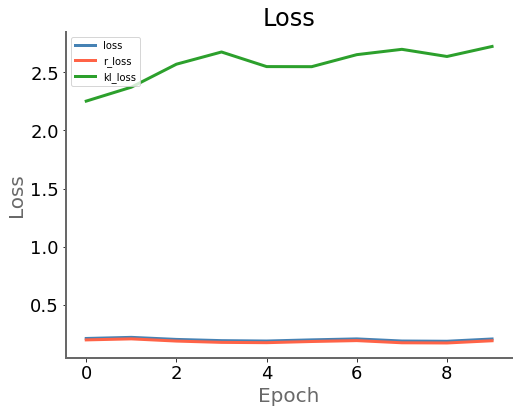

In [11]:
pwk.plot_history(history,  plot={"Loss":['loss','r_loss', 'kl_loss']}, save_as='history')

### 6.2 - Reconstruction (input -> encoder -> decoder)

<br>**Original images :**

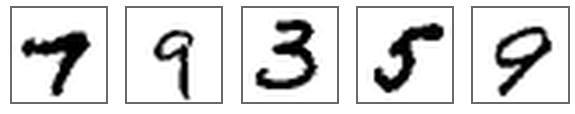

<br>**Encoded/decoded images**

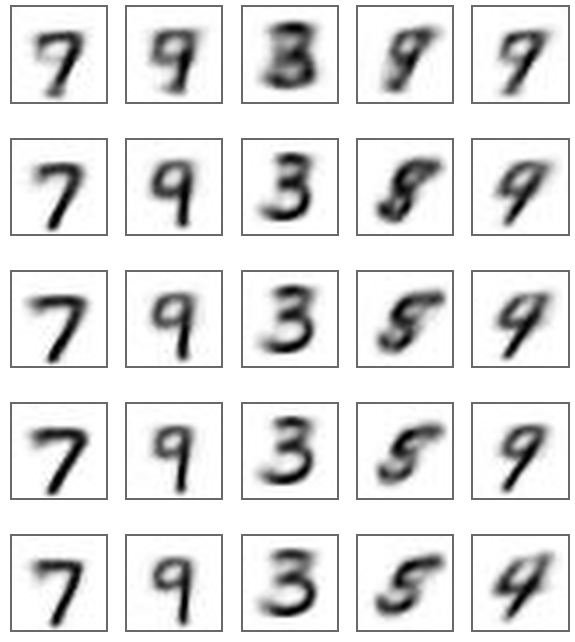

<br>**Original images :**

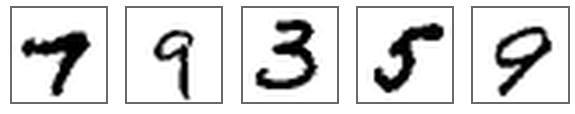

In [12]:
imgs=[]
labels=[]
for epoch in range(0,epochs,2):
    for i in range(5):
        filename = f'{run_dir}/images-encoded/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)
        

pwk.subtitle('Original images :')
pwk.plot_images(x_train[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)

pwk.subtitle('Encoded/decoded images')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, save_as='02-reconstruct')

pwk.subtitle('Original images :')
pwk.plot_images(x_train[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)


### 6.3 - Generation (latent -> decoder)

<br>**Generated images from latent space**

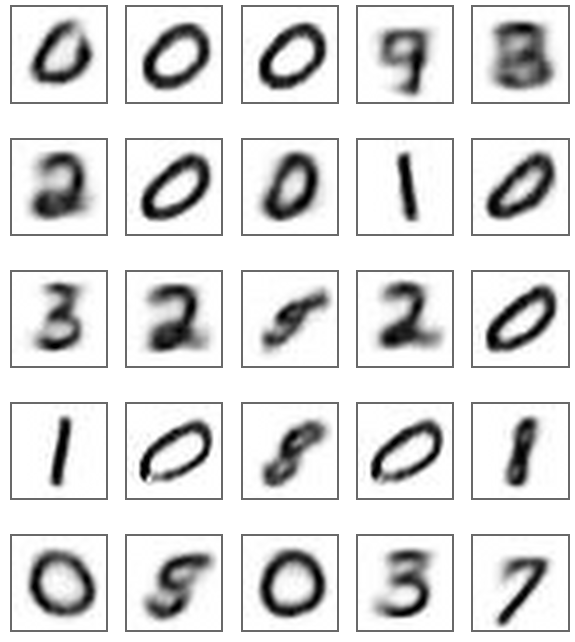

In [13]:
imgs=[]
labels=[]
for epoch in range(0,epochs,2):
    for i in range(5):
        filename = f'{run_dir}/images-generated/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)
        
pwk.subtitle('Generated images from latent space')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, save_as='03-encoded')


In [14]:
pwk.end()

End time is : Tuesday 09 February 2021, 19:59:50
Duration is : 00:01:15 852ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>